In [5]:
%matplotlib inline
import sys, os, time
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import rasterio
import fiona
import fiona.transform
import shapely.geometry

import subprocess

In [12]:
def hex_to_rgb(hex_string):
    hex_string = hex_string.lstrip("#")
    return tuple(int(hex_string[i:i+2], 16) / 256.0 for i in (0, 2, 4))

NLCD_CLASSES  = collections.OrderedDict([
    (11, ("Open Water", "#5475A8", "areas of open water, generally with less than 25% cover of vegetation or soil.")),
    (12, ("Perennial Ice/Snow", "#FFFFFF", "areas characterized by a perennial cover of ice and/or snow, generally greater than 25% of total cover.")),
    (21, ("Developed, Open Space", "#E8D1D1", "areas with a mixture of some constructed materials, but mostly vegetation in the form of lawn grasses. Impervious surfaces account for less than 20% of total cover. These areas most commonly include large-lot single-family housing units, parks, golf courses, and vegetation planted in developed settings for recreation, erosion control, or aesthetic purposes.")),
    (22, ("Developed, Low Intensity", "#E29E8C", "areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 20% to 49% percent of total cover. These areas most commonly include single-family housing units.")),
    (23, ("Developed, Medium Intensity", "#FF0000", "areas with a mixture of constructed materials and vegetation. Impervious surfaces account for 50% to 79% of the total cover. These areas most commonly include single-family housing units.")),
    (24, ("Developed High Intensity", "#B50000", "highly developed areas where people reside or work in high numbers. Examples include apartment complexes, row houses and commercial/industrial. Impervious surfaces account for 80% to 100% of the total cover.")),
    (31, ("Barren Land (Rock/Sand/Clay)", "#D2CDC0", "areas of bedrock, desert pavement, scarps, talus, slides, volcanic material, glacial debris, sand dunes, strip mines, gravel pits and other accumulations of earthen material. Generally, vegetation accounts for less than 15% of total cover.")),
    (41, ("Deciduous Forest", "#85C77E", "areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species shed foliage simultaneously in response to seasonal change.")),
    (42, ("Evergreen Forest", "#38814E", "areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. More than 75% of the tree species maintain their leaves all year. Canopy is never without green foliage.")),
    (43, ("Mixed Forest", "#D4E7B0", "areas dominated by trees generally greater than 5 meters tall, and greater than 20% of total vegetation cover. Neither deciduous nor evergreen species are greater than 75% of total tree cover.")),
    (52, ("Shrub/Scrub", "#DCCA8F", "areas dominated by shrubs; less than 5 meters tall with shrub canopy typically greater than 20% of total vegetation. This class includes true shrubs, young trees in an early successional stage or trees stunted from environmental conditions.")),
    (71, ("Grassland/Herbaceous", "#FDE9AA", "areas dominated by gramanoid or herbaceous vegetation, generally greater than 80% of total vegetation. These areas are not subject to intensive management such as tilling, but can be utilized for grazing.")),
    (81, ("Pasture/Hay", "#FBF65D", "areas of grasses, legumes, or grass-legume mixtures planted for livestock grazing or the production of seed or hay crops, typically on a perennial cycle. Pasture/hay vegetation accounts for greater than 20% of total vegetation.")),
    (82, ("Cultivated Crops", "#CA9146", "areas used for the production of annual crops, such as corn, soybeans, vegetables, tobacco, and cotton, and also perennial woody crops such as orchards and vineyards. Crop vegetation accounts for greater than 20% of total vegetation. This class also includes all land being actively tilled.")),
    (90, ("Woody Wetlands", "#C8E6F8", "areas where forest or shrubland vegetation accounts for greater than 20% of vegetative cover and the soil or substrate is periodically saturated with or covered with water.")),
    (95, ("Emergent Herbaceous Wetlands", "#64B3D5", "Areas where perennial herbaceous vegetation accounts for greater than 80% of vegetative cover and the soil or substrate is periodically saturated with or covered with water."))
])

HR_CLASSES = collections.OrderedDict([
    (1, ("Water", "#0000FF", "")),
    (2, ("Forest", "#007F00", "")),
    (3, ("Field", "#7FFF7F", "")),
    (4, ("Impervious Surfaces", "#7F6060", ""))
])

HR_LU_CLASSES = collections.OrderedDict([
    (1, ("Impervious, Road", "#000000", "")),
    (2, ("Impervious, Non-Road", "#730e04", "")),
    (3, ("Tree Canopy over Impervious Surfaces", "#7df707", "")),
    (4, ("Water", "#1870ff", "")),
    (5, ("Tidal Wetlands", "#7afac5", "")),
    (6, ("Floodplain Wetlands", "#70e6a9", "")),
    (7, ("Other Wetlands", "#70e6a9", "")),
    (8, ("Forest", "#377301", "")),
    (9, ("Tree Canopy over Turf Grass", "#a7f804", "")),
    (10, ("Mixed Open", "#a86f00", "")),
    (11, ("Fractional Turf (small)", "#f3bde8", "")),
    (12, ("Fractional Turf (med)", "#f3bde8", "")),
    (13, ("Fractional Turf (large)", "#f3bde8", "")),
    (14, ("Fractional Impervious", "#c746ff", "")),
    (15, ("Turf Grass", "#fefb73", "")),
    (16, ("Cropland", "#e69800", "")),
    (17, ("Pasture/Hay", "#e69800", ""))
])

HR_CLASSES_CMAP = matplotlib.colors.ListedColormap([
    HR_CLASSES[i][1] if i in HR_CLASSES else "#000000"
    for i in range(0, max(HR_CLASSES)+1)
])

HR_LU_CLASSES_CMAP = matplotlib.colors.ListedColormap([
    HR_LU_CLASSES[i][1] if i in HR_LU_CLASSES else "#000000"
    for i in range(0, max(HR_LU_CLASSES)+1)
])

NLCD_CLASSES_CMAP = matplotlib.colors.ListedColormap([
    NLCD_CLASSES[i][1] if i in NLCD_CLASSES else "#000000"
    for i in range(0, max(NLCD_CLASSES)+1)
])

In [22]:
with rasterio.open("/home/caleb/data/md_1m_2013_extended-test_tiles/m_3807502_se_18_1_naip-new.tif") as f:
    naip_new_data = np.rollaxis(f.read(), 0, 3)

In [23]:
with rasterio.open("/home/caleb/data/md_1m_2013_extended-test_tiles/m_3807502_se_18_1_naip-old.tif") as f:
    naip_old_data = np.rollaxis(f.read(), 0, 3)

In [9]:
with rasterio.open("/home/caleb/data/md_1m_2013_extended-test_tiles/m_3807502_se_18_1_lc.tif") as f:
    lc_data = f.read().squeeze()

In [16]:
with rasterio.open("/home/caleb/data/landuse/md_1m_2013_extended-test_tiles/m_3807502_se_18_1_lu.tif") as f:
    lu_data = f.read().squeeze()

In [24]:
x,y = 0,0
width, height = 256, 256
naip_new_img = naip_new_data[y:y+height,x:x+width,:3]
naip_old_img = naip_old_data[y:y+height,x:x+width,:3]
lc_img = lc_data[y:y+height,x:x+width]
lu_img = lu_data[y:y+height,x:x+width]

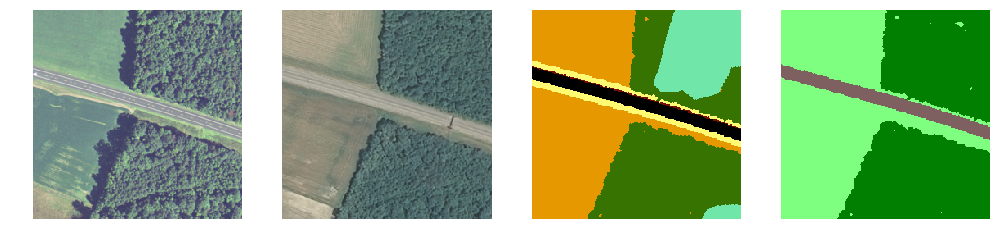

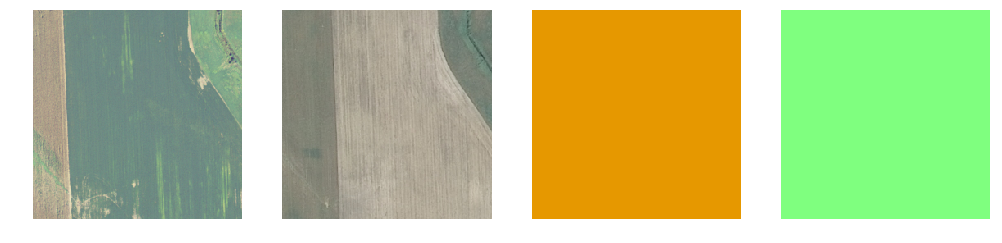

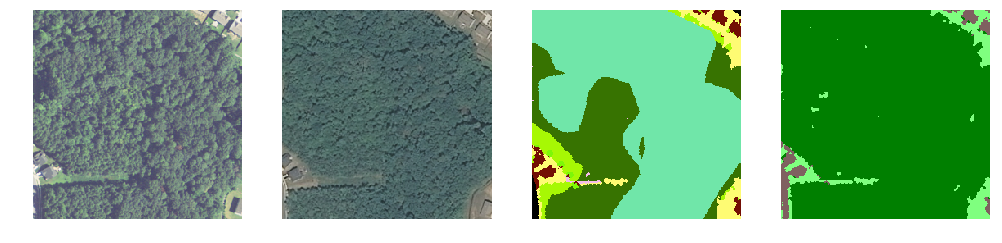

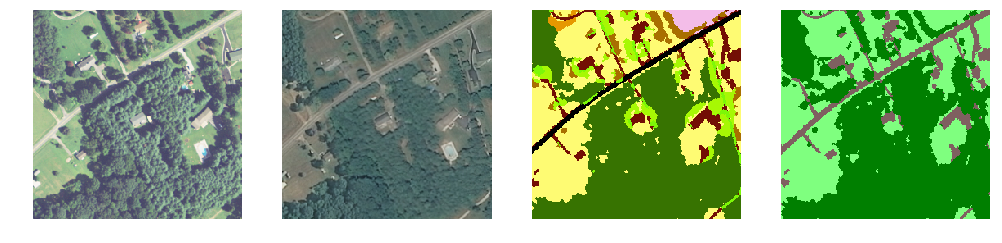

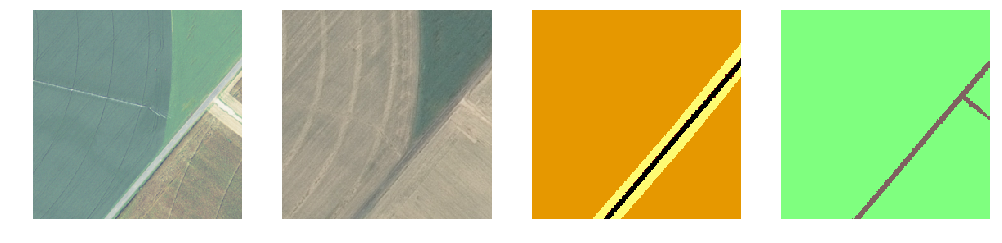

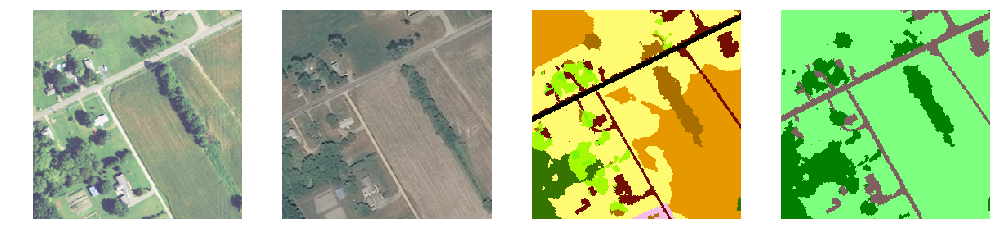

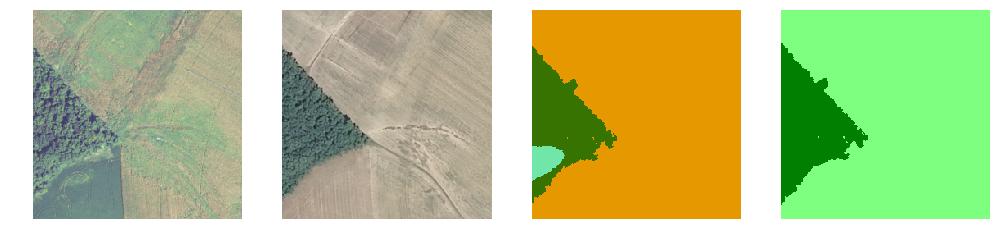

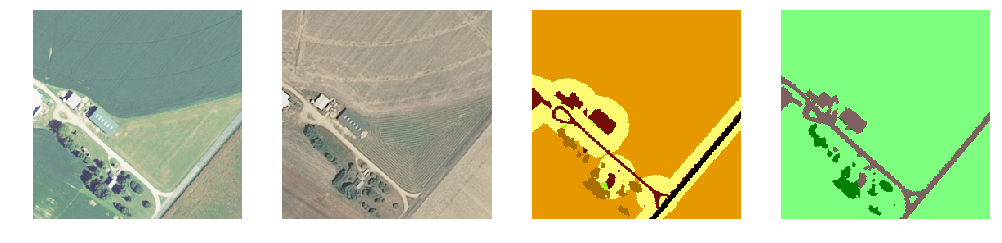

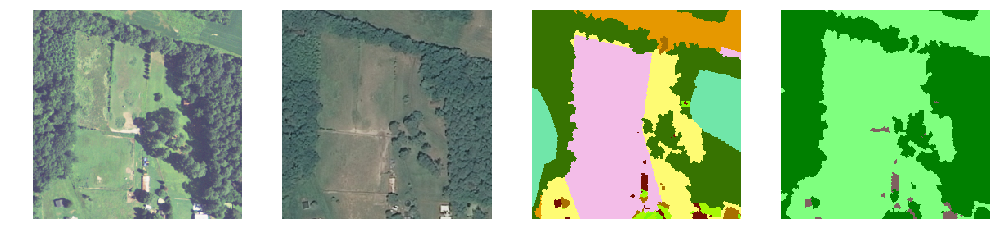

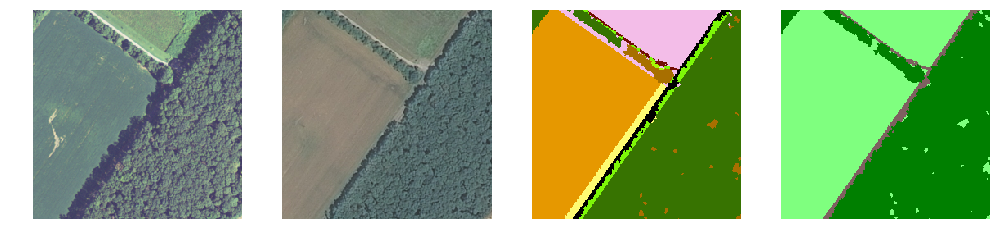

In [28]:

for i in range(10):

    
    width, height = 256, 256
    x = np.random.randint(0, lc_data.shape[1]-width)
    y = np.random.randint(0, lc_data.shape[0]-height)
    naip_new_img = naip_new_data[y:y+height,x:x+width,:3]
    naip_old_img = naip_old_data[y:y+height,x:x+width,:3]
    lc_img = lc_data[y:y+height,x:x+width]
    lu_img = lu_data[y:y+height,x:x+width]

    fig, axs = plt.subplots(1,4,figsize=(14,4))

    axs[0].imshow(naip_new_img)
    axs[0].axis("off")
    axs[1].imshow(naip_old_img)
    axs[1].axis("off")
    axs[2].imshow(lu_img, cmap=HR_LU_CLASSES_CMAP, vmin=0, vmax=HR_LU_CLASSES_CMAP.N)
    axs[2].axis("off")
    axs[3].imshow(lc_img, cmap=HR_CLASSES_CMAP, vmin=0, vmax=HR_CLASSES_CMAP.N)
    axs[3].axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()